In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import numpy as np
import wandb
from wandb.keras import WandbMetricsLogger
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import backend as K

2023-07-03 03:27:12.772052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 03:27:13.597454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


2023-07-03 03:27:16.154095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 38201 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-07-03 03:27:16.162306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 38201 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [3]:
image_height = 128
image_width = 128
batch_size = 64
class_names = ['im_Dyskeratotic', 'im_Superficial-Intermediate', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal']

In [4]:
dataset_train_original, dataset_valid_original = image_dataset_from_directory('SipakMed',
                                                            labels='inferred',
                                                            label_mode='int',
                                                            class_names=class_names,
                                                            image_size=(image_height,image_width),
                                                            batch_size=None,
                                                            shuffle=True,
                                                            seed=23,
                                                            validation_split=0.2,
                                                            subset='both',
                                                            crop_to_aspect_ratio=False)

Found 4049 files belonging to 5 classes.
Using 3240 files for training.
Using 809 files for validation.


2023-07-03 03:27:16.701191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38201 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [5]:
# Function to scale RGB values. No other preprocessing required
def preprocess(image, label):
    # image /= 255.0
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # label = tf.cast(label, tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image, label


In [6]:
# Functions to randomly augment the images

def augment_geometric(image, label, flip_left_right=True, flip_up_down=True):
    image_augmented = image
    if flip_left_right:
        image_augmented = tf.image.random_flip_left_right(image_augmented)
    if flip_up_down:
        image_augmented = tf.image.random_flip_up_down(image_augmented)
    return image_augmented, label

def augment_appearance(image, label, hue=0.25, brightness=0.25, contrast=0.5, saturation=0.5):
    image_augmented = image
    if hue > 0:
        image_augmented = tf.image.random_hue(image_augmented, hue)
    if brightness > 0:
        image_augmented = tf.image.random_brightness(image_augmented, brightness)
    if contrast > 0:
        image_augmented = tf.image.random_contrast(image_augmented, lower=max(0, 1.0-contrast), upper=1.0+contrast)
    if saturation > 0:
        image_saturation = tf.image.random_saturation(image_augmented, lower=max(0, 1.0-saturation), upper=1.0+saturation)
    image_augmented = tf.clip_by_value(image_augmented, 0.0, 1.0)
    return image_augmented, label


In [7]:
# Function to systematically augment the images

def augment_all_geometric(image, label, flip_left_right=True, flip_up_down=True):
    image_augmented = image
    if flip_left_right:
        image_augmented = tf.image.flip_left_right(image_augmented)
    if flip_up_down:
        image_augmented = tf.image.flip_up_down(image_augmented)
    return image_augmented, label


In [8]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michlun. Use `wandb login --relogin` to force relogin


True

In [9]:
history_list = {}


In [10]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()

    plt.plot(history["class2_recall"], label="class2_recall")
    plt.plot(history["val_class2_recall"], label="val_class2_recall")
    plt.legend()
    plt.title("Our class2_recall")
    plt.show()
    plt.close()

    

def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()
    for training_name, history in history_list.items():
        plt.plot(history["val_class2_recall"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_class2_recall")
    plt.show()
    plt.close()
   

In [11]:
def class_recall(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    possible_postives = K.sum(true_c)
    return true_positives / (possible_postives + K.epsilon())

def class_precision(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    pred_positives = K.sum(pred_c)
    return true_positives / (pred_positives + K.epsilon())
    
def class2_recall(y_true, y_pred):
    return class_recall(y_true, y_pred, 2)

def class2_precision(y_true, y_pred):
     return class_precision(y_true, y_pred, 2)


In [40]:
# Preprocess the datasets

dataset_train = dataset_train_original.map(lambda x, y: preprocess(x,y))
dataset_valid = dataset_valid_original.map(lambda x, y: preprocess(x,y))


In [41]:
# Augment the train dataset

dataset_augmented_geom_1 = dataset_train.map(lambda x, y: augment_all_geometric(x,y,flip_left_right=True,flip_up_down=False))
dataset_augmented_geom_2 = dataset_train.map(lambda x, y: augment_all_geometric(x,y,flip_left_right=False,flip_up_down=True))
dataset_augmented_geom_3 = dataset_train.map(lambda x, y: augment_all_geometric(x,y,flip_left_right=True,flip_up_down=True))

dataset_train = dataset_train.concatenate(dataset_augmented_geom_1)
dataset_train = dataset_train.concatenate(dataset_augmented_geom_2)
dataset_train = dataset_train.concatenate(dataset_augmented_geom_3)


In [42]:
# dataset_augmented_appear = dataset_train.map(lambda x, y: augment_appearance(x,y))
# dataset_train = dataset_train.concatenate(dataset_augmented_appear)

In [43]:
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(12960)
dataset_train = dataset_train.batch(batch_size)

dataset_valid = dataset_valid.cache()
dataset_valid = dataset_valid.batch(batch_size)

In [44]:
model_name = "vgg19_128x128_flat_1dense128_finetune"
epochs = 10
lr = 0.0001
wandb.init(project="cervical-cancer-sipakmed",
           name=model_name,
           config={"model": model_name,
                   "epochs": epochs,
                   "learning rate": lr,
                   "image size": str(image_height)+"x"+str(image_width),
                   "batch size": batch_size})

In [45]:
tf.keras.backend.clear_session()

base_net = tf.keras.applications.VGG19(
    include_top=False,
    # pooling='max',
    weights='imagenet',
    # classes=5,
    # classifier_activation='softmax',
    input_shape=(image_height,image_width,3)
)
base_net.trainable = False
x = base_net.output
# x = layers.Flatten()(x)
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.2)(x)  # Regularize with dropout
x = layers.Dense(128, activation='relu')(x)
# x = layers.Dense(4096, activation='relu')(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = models.Model(inputs=base_net.input, outputs=predictions)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [46]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", class2_recall]
)

In [47]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_valid,
    # callbacks=[WandbMetricsLogger()],
    # workers=4,
    # use_multiprocessing=True
)


Epoch 1/10


2023-07-03 03:33:26.834041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_36' with dtype int32 and shape [3240]
	 [[{{node Placeholder/_36}}]]
2023-07-03 03:33:26.834586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int32 and shape [3240]
	 [[{{node Placeholder/_19}}]]


202/203 [============================>.] - ETA: 0s - loss: 1.5984 - accuracy: 0.5751 - class2_recall: 0.4928

2023-07-03 03:33:32.445593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [809]
	 [[{{node Placeholder/_4}}]]
2023-07-03 03:33:32.445817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [809]
	 [[{{node Placeholder/_4}}]]


203/203 [==============================] - 6s 21ms/step - loss: 1.5956 - accuracy: 0.5758 - class2_recall: 0.4933 - val_loss: 0.6697 - val_accuracy: 0.7824 - val_class2_recall: 0.6760
Epoch 2/10
203/203 [==============================] - 4s 19ms/step - loss: 0.4864 - accuracy: 0.8265 - class2_recall: 0.7211 - val_loss: 0.4626 - val_accuracy: 0.8455 - val_class2_recall: 0.7478
Epoch 3/10
203/203 [==============================] - 4s 20ms/step - loss: 0.3379 - accuracy: 0.8779 - class2_recall: 0.7913 - val_loss: 0.3913 - val_accuracy: 0.8752 - val_class2_recall: 0.7743
Epoch 4/10
203/203 [==============================] - 4s 19ms/step - loss: 0.2633 - accuracy: 0.9028 - class2_recall: 0.8239 - val_loss: 0.3571 - val_accuracy: 0.8875 - val_class2_recall: 0.7483
Epoch 5/10
203/203 [==============================] - 4s 21ms/step - loss: 0.2183 - accuracy: 0.9180 - class2_recall: 0.8504 - val_loss: 0.3323 - val_accuracy: 0.8949 - val_class2_recall: 0.7998
Epoch 6/10
203/203 [================

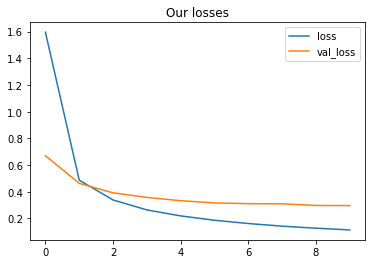

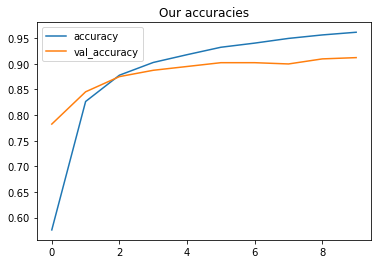

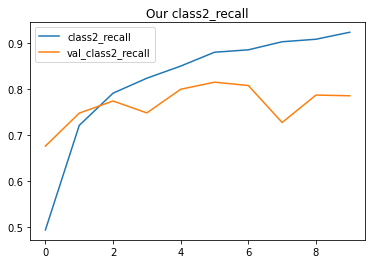

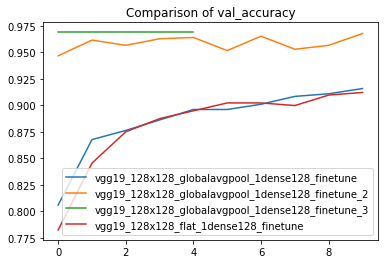

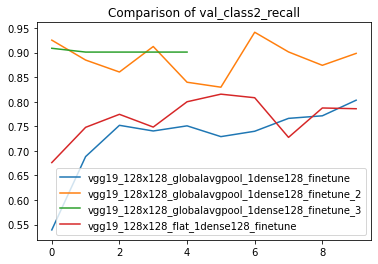

In [48]:
history_list[model_name] = history.history
render_history(history.history)
compare_histories()

In [49]:
model_name = model_name + "_2"
epochs = 10
lr = 0.00005


In [50]:
wandb.config.update({"epochs finetune": epochs,
                    "learning rate finetune": lr,
                    })

In [51]:
base_net.trainable = True

In [52]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d True
23 dense True
24 dense_1 True


In [53]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", class2_recall]
)

In [54]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_valid,
    # callbacks=[WandbMetricsLogger()],
)


Epoch 1/10
203/203 [==============================] - 14s 49ms/step - loss: 0.2227 - accuracy: 0.9258 - class2_recall: 0.8659 - val_loss: 0.2369 - val_accuracy: 0.9258 - val_class2_recall: 0.8655
Epoch 2/10
203/203 [==============================] - 10s 48ms/step - loss: 0.0817 - accuracy: 0.9718 - class2_recall: 0.9466 - val_loss: 0.2429 - val_accuracy: 0.9345 - val_class2_recall: 0.7664
Epoch 3/10
203/203 [==============================] - 10s 48ms/step - loss: 0.0453 - accuracy: 0.9838 - class2_recall: 0.9638 - val_loss: 0.1584 - val_accuracy: 0.9444 - val_class2_recall: 0.8160
Epoch 4/10
203/203 [==============================] - 10s 47ms/step - loss: 0.0285 - accuracy: 0.9901 - class2_recall: 0.9806 - val_loss: 0.1677 - val_accuracy: 0.9530 - val_class2_recall: 0.8176
Epoch 5/10
203/203 [==============================] - 10s 48ms/step - loss: 0.0176 - accuracy: 0.9942 - class2_recall: 0.9883 - val_loss: 0.2128 - val_accuracy: 0.9468 - val_class2_recall: 0.7867
Epoch 6/10
203/203 [

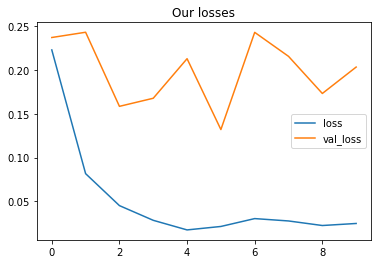

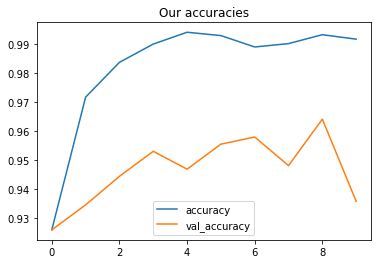

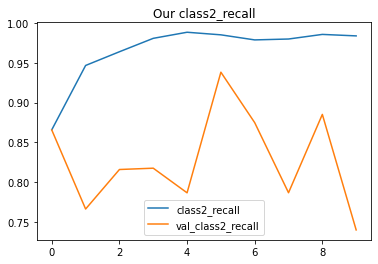

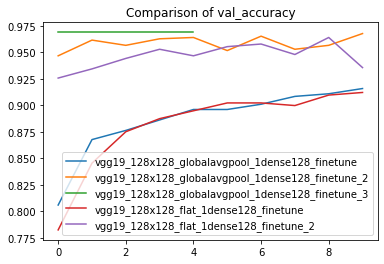

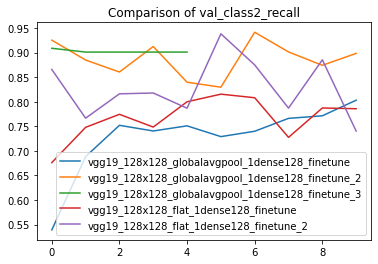

In [55]:
history_list[model_name] = history.history
render_history(history.history)
compare_histories()

In [56]:
model_name = model_name.replace("_2","_3")
epochs = 5
lr = 0.00001


In [57]:
wandb.config.update({"epochs finetune": epochs,
                    "learning rate finetune": lr,
                    })

In [58]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", class2_recall]
)

In [59]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_valid,
    callbacks=[WandbMetricsLogger()],
)


Epoch 1/5
203/203 [==============================] - 14s 49ms/step - loss: 0.0045 - accuracy: 0.9983 - class2_recall: 0.9951 - val_loss: 0.1082 - val_accuracy: 0.9790 - val_class2_recall: 0.9401
Epoch 2/5
203/203 [==============================] - 10s 49ms/step - loss: 9.8970e-05 - accuracy: 1.0000 - class2_recall: 1.0000 - val_loss: 0.1143 - val_accuracy: 0.9802 - val_class2_recall: 0.9401
Epoch 3/5
203/203 [==============================] - 10s 48ms/step - loss: 3.5290e-05 - accuracy: 1.0000 - class2_recall: 1.0000 - val_loss: 0.1262 - val_accuracy: 0.9790 - val_class2_recall: 0.9355
Epoch 4/5
203/203 [==============================] - 10s 49ms/step - loss: 1.9032e-05 - accuracy: 1.0000 - class2_recall: 1.0000 - val_loss: 0.1321 - val_accuracy: 0.9802 - val_class2_recall: 0.9401
Epoch 5/5
203/203 [==============================] - 10s 49ms/step - loss: 1.1481e-05 - accuracy: 1.0000 - class2_recall: 1.0000 - val_loss: 0.1372 - val_accuracy: 0.9815 - val_class2_recall: 0.9446


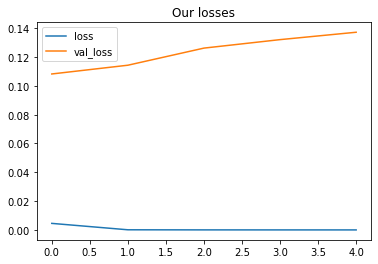

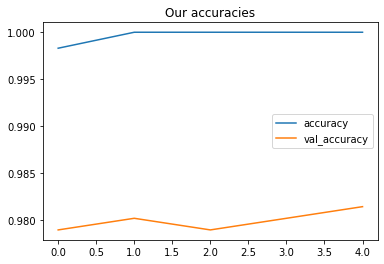

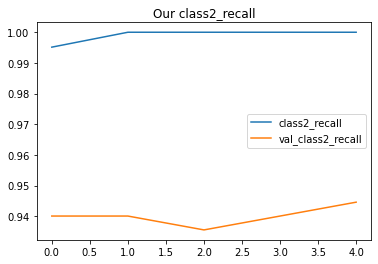

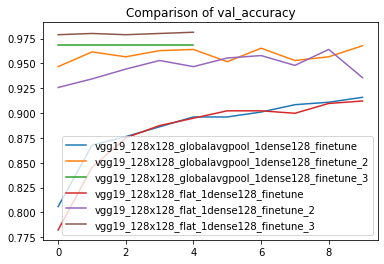

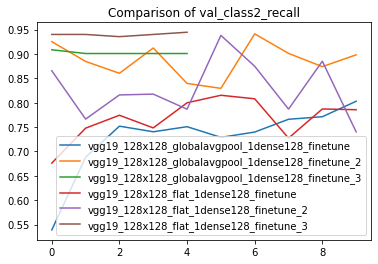

In [60]:
history_list[model_name] = history.history
render_history(history.history)
compare_histories()

In [61]:
model.save('vgg19_single_cell.h5', save_format='h5')

In [62]:
pred = model.predict(dataset_valid)
predictions = []
for p in pred:
    predictions.append(p.argmax())


13/13 [==============================] - 0s 23ms/step


In [63]:
images, labels = zip(*dataset_valid.unbatch())
conf_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions, dtype=float).numpy()
print(conf_matrix)

2023-07-03 03:37:53.990119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [809]
	 [[{{node Placeholder/_0}}]]
2023-07-03 03:37:53.990389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [809]
	 [[{{node Placeholder/_4}}]]


[[166.   0.   0.   0.   0.]
 [  1. 175.   0.   0.   0.]
 [  4.   1. 149.   3.   0.]
 [  0.   1.   2. 146.   0.]
 [  1.   0.   0.   2. 158.]]


In [64]:
for row in range(5):
    conf_matrix[row, :] /= labels.count(row)
    conf_matrix[row, :] *= 100
print(conf_matrix.round(1))

[[100.    0.    0.    0.    0. ]
 [  0.6  99.4   0.    0.    0. ]
 [  2.5   0.6  94.9   1.9   0. ]
 [  0.    0.7   1.3  98.    0. ]
 [  0.6   0.    0.    1.2  98.1]]


In [65]:
c2_recall = (np.array(class2_recall(labels,pred))* 100).round(2)
print('Class 2 recall:', c2_recall)

Class 2 recall: 94.9


In [66]:
labels=list(labels)
labels_numpy = [l.numpy() for l in labels]

In [67]:
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels_numpy, preds=predictions,
                        class_names=class_names)})
wandb.log({"class2_recall" : c2_recall})
wandb.finish()

class2_recall,▁
epoch/accuracy,▁████
epoch/class2_recall,▁████
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/val_accuracy,▁▅▁▅█
epoch/val_class2_recall,▅▅▁▅█
epoch/val_loss,▁▂▅▇█
class2_recall,94.9
epoch/accuracy,1.0
